In [98]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [99]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [101]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [102]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [103]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [104]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# assign the station class to a variable called `Station`
Station = Base.classes.station


In [105]:
# Create a session
session = Session(engine)


# Exploratory Precipitation Analysis

In [106]:
# Find the most recent date in the data set.
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1fded12ad50>,
 'prcp': 2.0,
 'id': 0,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'tobs': 18.3}

In [107]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

# Calculate the date one year from the last date in data set.
most_recent_date_dt = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
start_date = most_recent_date_dt - dt.timedelta(days=365)
print(start_date)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])
# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date')
precip_df.head(5)

# Use Pandas Plotting with Matplotlib to plot the data


2017-08-23
2016-08-23 00:00:00


,date,prcp
0,2016-08-24,2.0
1,2016-08-24,54.6
2,2016-08-24,57.9
3,2016-08-24,NaN
4,2016-08-24,31.0


<Figure size 1000x600 with 0 Axes>

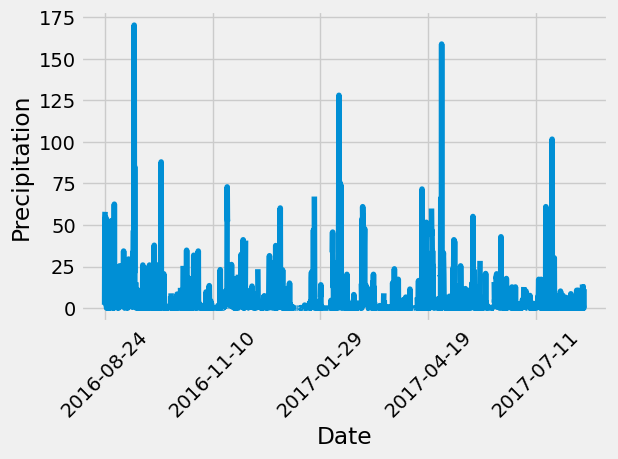

In [108]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.set_index('date', inplace=True)

plt.figure(figsize=(10, 6))
precip_df.plot(y='prcp', legend=False)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Exploratory Station Analysis

In [109]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Measurement.station))).scalar()
total_stations

9

In [110]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label("count"))
    .group_by(Measurement.station)
    .order_by(sqlalchemy.desc("count"))
    .all()
)
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [111]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label("min_temp"),
        func.max(Measurement.tobs).label("max_temp"),
        func.avg(Measurement.tobs).label("avg_temp"),
    )
    .filter(Measurement.station == most_active_station_id)
    .one()
)
temperature_stats

(12.2, 29.4, 22.035822510822513)

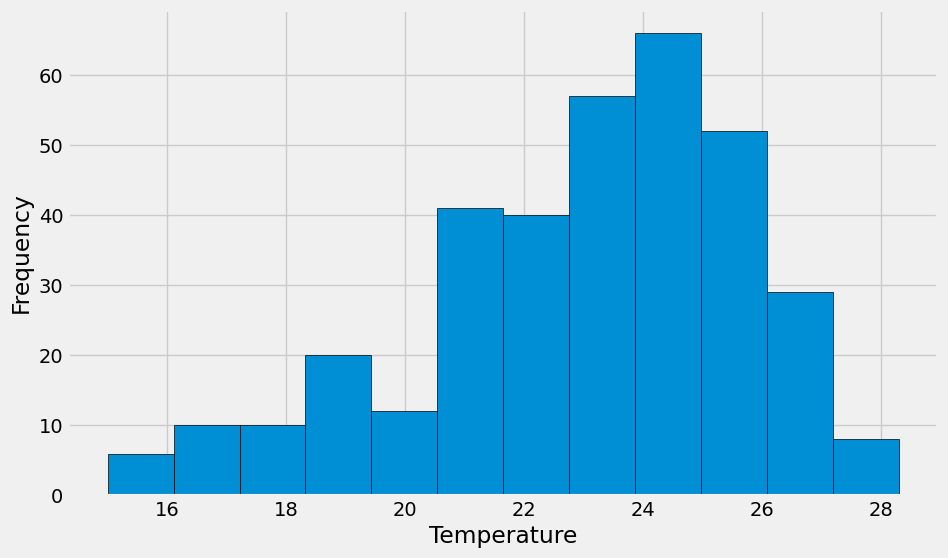

In [112]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= start_date)
    .all()
)
temperatures = [temp[0] for temp in temperature_data]
temperatures

# Plot the data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor="black")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [113]:
# Close Session
session.close()
